In [1]:

import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain_community.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
openai_api_key = ""

In [3]:
output_path = "./images"

In [4]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename="./AC-Aids-for-Dogs_Canine-Periodontal-Disease.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

In [21]:
text_summaries

["Canine Periodontal Disease (PD) is a bacterial infection that causes inflammation of the tissues and bone surrounding and supporting a dog's teeth. It is also known as dental disease. PD develops when plaque forms along the gumline and hardens into tartar, irritating the gums and causing inflammation called gingivitis. If left untreated, the tartar builds up under the gum line, resulting in PD. Dogs may experience pain, infection, abscesses, and tooth loss as the disease progresses. Certain risk factors for PD include excessive drooling, licking, loss of appetite, repeated pawing or rubbing of the face, weight loss, aggression, head shyness, swelling of the face, and difficulty chewing. Age, muzzle length, and breed can also increase the risk of PD. PD can lead to significant health and welfare problems, such as kidney disease, liver disease, tooth loss, heart disease, and bleeding gums. If any signs of PD are observed in a dog, it is recommended to consult with a veterinarian for tr

In [9]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai
genai.configure(api_key="")


In [12]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        HumanMessage(content=[
            {
                "type": "text",
                "text": "You are a bot that is good at analyzing images related to Dog's health. Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatGoogleGenerativeAI(model="gemini-pro-vision", google_api_key="").invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)
     


In [22]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    print(type(s))
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

<class 'str'>
<class 'str'>


In [23]:
vectorstore.save_local("faiss_index")

In [24]:
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [25]:

db = FAISS.load_local("faiss_index", embeddings)

In [26]:
prompt_template = """
You are a vet doctor and an expert in analyzing dog's health.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [27]:
qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [28]:
def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [29]:

result, relevant_images = answer("What is Gingivitis?")
print(result)

Gingivitis is an inflammation of the gums that occurs due to the accumulation of plaque and tartar on the teeth. In the context provided, it is mentioned that when food and bacteria collect along the gumline, plaque forms, and over time, it hardens into tartar. The tartar irritates the gums, leading to inflammation, which is known as gingivitis. 

If left untreated, gingivitis can progress to a more serious condition called periodontitis, which is an infection of the gums and the bone that supports the teeth. Periodontitis can cause pain, infection, abscesses, and tooth loss in dogs.

The context also includes images of a dog's tooth covered in plaque and tartar, as well as a dog's teeth with yellow/orange tartar and gingivitis. Additionally, it mentions that gingivitis is characterized by redness and inflammation at the gumline and a large amount of yellowish material on the teeth.

Therefore, based on the information and visuals provided, it can be concluded that gingivitis is an inf

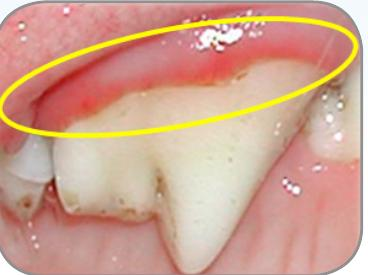

In [34]:
display.display(display.Image(base64.b64decode(relevant_images[0])))